In [2]:
import numpy as np
from scipy.signal import sawtooth, square
import matplotlib.pyplot as plt
from scipy.signal import lfilter, butter, sosfilt
import soundfile as sf
import librosa
from scipy.io import wavfile
import scipy.signal
import scipy.signal
import scipy.fftpack


# <font color = 'green'> **Osillator**

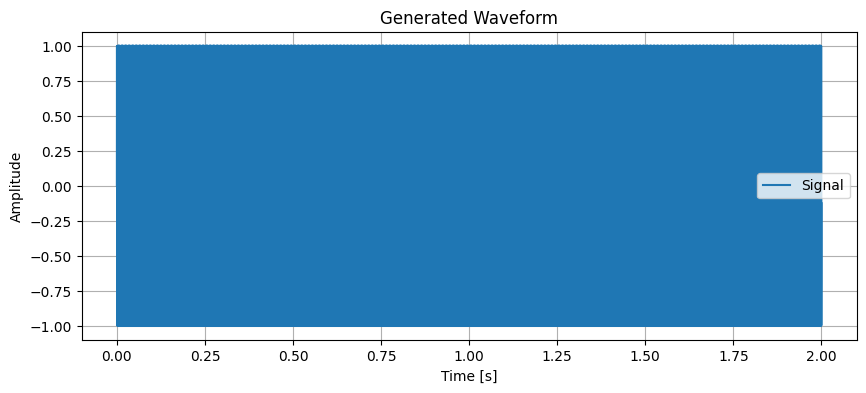

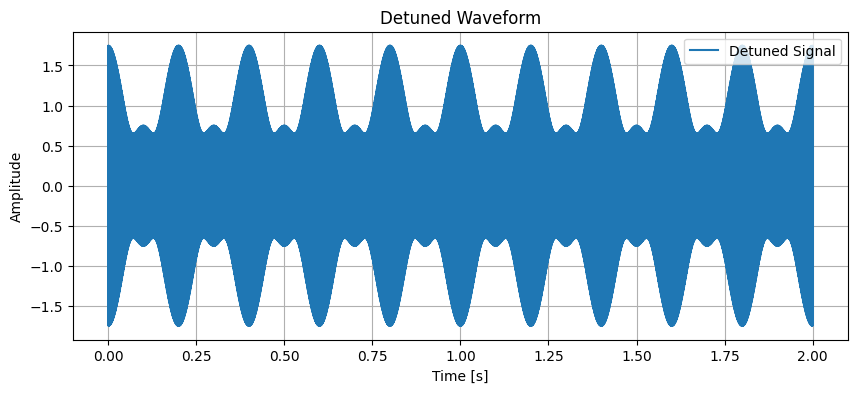

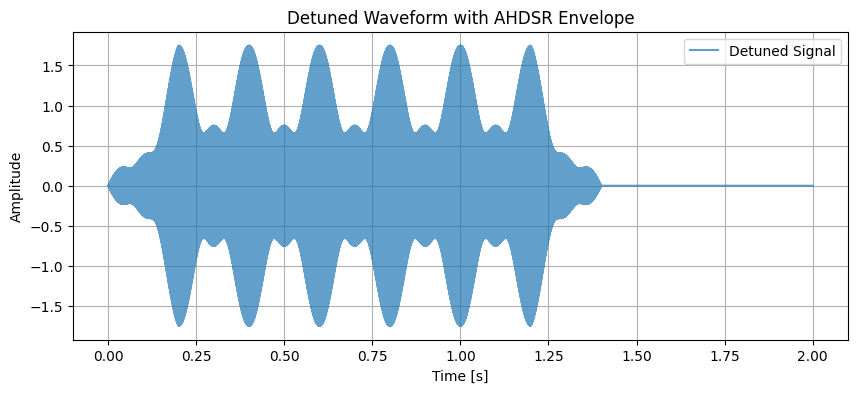

In [7]:
def generate_waveform(wave_type, t, frequency, phase, amplitude):
    if wave_type == 'sine':
        return amplitude * np.sin(2 * np.pi * frequency * t + phase)
    elif wave_type == 'sawtooth':
        return amplitude * sawtooth(2 * np.pi * frequency * t + phase)
    elif wave_type == 'triangle':
        return amplitude * sawtooth(2 * np.pi * frequency * t + phase, 0.5)
    elif wave_type == 'square':
        return amplitude * square(2 * np.pi * frequency * t + phase)
    else:
        raise ValueError("Invalid wave type")

def detuned_wave(wave_type, t, base_frequency, phase, volume, N, Ais, fis):
    waveform = np.zeros_like(t)
    for i in range(N):
        fi = base_frequency + fis[i]
        Ai = volume * Ais[i]
        waveform += generate_waveform(wave_type, t, fi, phase, Ai)
    return waveform

def apply_ahdsr_envelope(waveform, t, attack, hold, decay, sustain, release, note_length):
    total_samples = len(t)
    env = np.zeros_like(t)
    
    attack_samples = min(int(attack * total_samples), total_samples)
    hold_samples = min(int(hold * total_samples), total_samples - attack_samples)
    decay_samples = min(int(decay * total_samples), total_samples - attack_samples - hold_samples)
    sustain_samples = min(int(note_length * total_samples), total_samples - attack_samples - hold_samples - decay_samples)
    release_samples = min(int(release * total_samples), total_samples - attack_samples - hold_samples - decay_samples - sustain_samples)
    
    sustain_level = sustain

    env[:attack_samples] = np.linspace(0, 1, attack_samples)  # Linear attack
    env[attack_samples:attack_samples + hold_samples] = 1  # Hold level
    env[attack_samples + hold_samples:attack_samples + hold_samples + decay_samples] = \
        np.linspace(1, sustain_level, decay_samples)  # Decay to sustain level

    note_end = attack_samples + hold_samples + decay_samples + sustain_samples
    if note_end < total_samples:
        env[note_end:note_end + release_samples] = \
            np.linspace(sustain_level, 0, release_samples)  # Release phase
        env[note_end + release_samples:] = 0  # Ensure envelope goes to 0

    return waveform * env

# Example usage
sample_rate = 44100
duration = 2  # seconds
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

wave_type = 'sine'
base_frequency = 880.0  # Hz (A4)
phase = 0.0
volume = 1.0
N = 3
Ais = [1.0, 0.5, 0.25]
fis = [0.0, 5.0, 10.0]

wave = generate_waveform(wave_type, t, base_frequency, phase, volume)

waveform = detuned_wave(wave_type, t, base_frequency, phase, volume, N, Ais, fis)

attack = 0.1  
hold = 0.5   
decay = 0.1 
sustain = 0
release = 2  
note_length = 1.0  # seconds

enveloped_waveform = apply_ahdsr_envelope(waveform, t, attack, hold, decay, sustain, release, note_length)

# Generated wave
plt.figure(figsize=(10, 4))
plt.plot(t, wave, label='Signal')
plt.title('Generated Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()
# Detuned wave
plt.figure(figsize=(10, 4))
plt.plot(t, waveform, label='Detuned Signal')
plt.title('Detuned Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()
# Plot the waveform and envelope
plt.figure(figsize=(10, 4))
plt.plot(t, enveloped_waveform, label='Detuned Signal', alpha=0.7)
plt.title('Detuned Waveform with AHDSR Envelope')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# <font color = 'green'> **Effect 1 : Phaser**

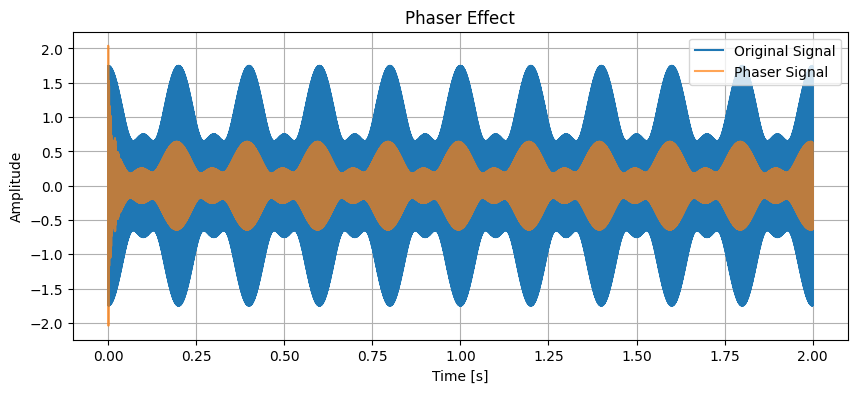

In [8]:
def all_pass_filter(input_signal, delay, feedback):
    # Initialize the delay buffer
    buffer = np.zeros(delay)
    output_signal = np.zeros_like(input_signal)
    
    for i in range(len(input_signal)):
        buffer_out = buffer[-1]
        buffer[1:] = buffer[:-1]
        buffer[0] = input_signal[i] + feedback * buffer_out
        output_signal[i] = buffer_out - feedback * buffer[0]
    
    return output_signal

def phaser_effect(input_signal, sample_rate, num_stages=4, feedback=0.7, depth=0.7):
    delay = int(sample_rate / 1000)  # 1ms delay
    signal = input_signal
    for _ in range(num_stages):
        signal = all_pass_filter(signal, delay, feedback)
    output_signal = input_signal + depth * signal
    return output_signal

# Example usage

waveform = detuned_wave(wave_type, t, base_frequency, phase, volume, N, Ais, fis)
phaser_signal = phaser_effect(waveform, sample_rate)

plt.figure(figsize=(10, 4))
plt.plot(t, waveform, label='Original Signal')
plt.plot(t, phaser_signal, label='Phaser Signal', alpha=0.7)
plt.title('Phaser Effect')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# <font color = 'green'> **Effect 2 : Flanger**

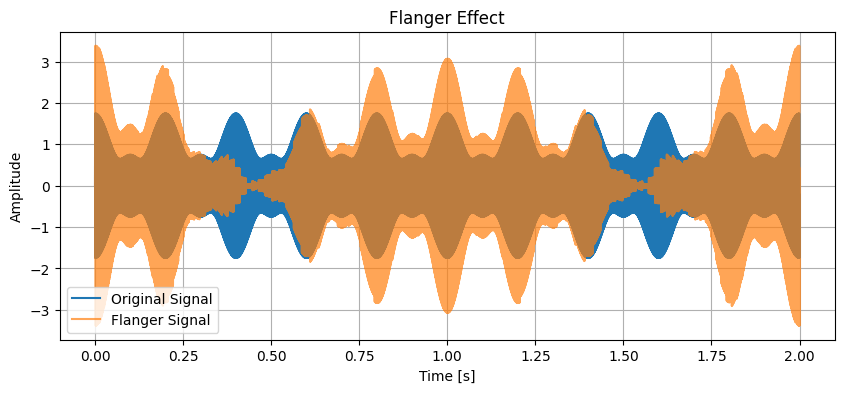

In [9]:
def flanger_effect(input_signal, sample_rate, max_delay=0.003, depth=0.7, rate=0.25):
    num_samples = len(input_signal)
    output_signal = np.zeros(num_samples)
    
    max_delay_samples = int(max_delay * sample_rate)
    mod_signal = (depth / 2) * (1 + np.sin(2 * np.pi * rate * np.arange(num_samples) / sample_rate))
    
    for n in range(num_samples):
        delay_samples = int(mod_signal[n] * max_delay_samples)
        if n - delay_samples < 0:
            output_signal[n] = input_signal[n]
        else:
            output_signal[n] = input_signal[n] + input_signal[n - delay_samples]
    
    return output_signal

# Example usage
flanger_signal = flanger_effect(waveform, sample_rate)

plt.figure(figsize=(10, 4))
plt.plot(t, waveform, label='Original Signal')
plt.plot(t, flanger_signal, label='Flanger Signal', alpha=0.7)
plt.title('Flanger Effect')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# <font color = 'green'> **Effect 3 : Chorus**

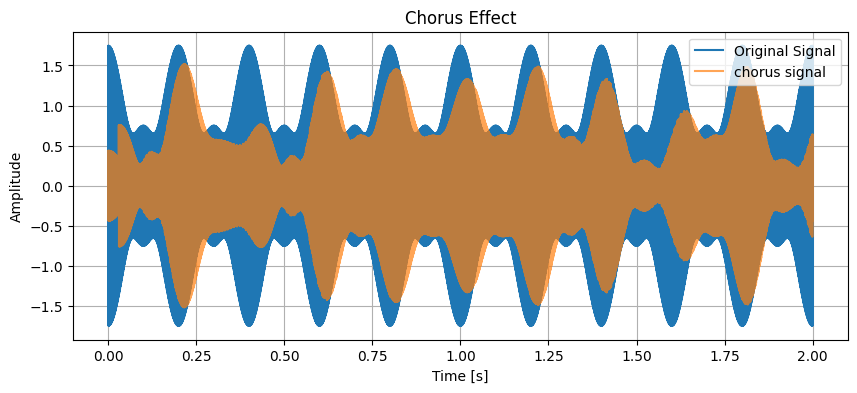

In [10]:
import numpy as np
from scipy.io import wavfile

def apply_chorus(signal, rate, delay_times=[13, 23, 30], modulation_depth=0.002, modulation_speed=0.25):
    chorus_signal = signal.copy()
    max_delay_samples = int(max(delay_times) * rate / 1000)
    
    
    t = np.arange(len(signal))
    lfo = (np.sin(2 * np.pi * modulation_speed * t / rate) * modulation_depth * rate).astype(int)

    for delay in delay_times:
        delay_samples = int(delay * rate / 1000)
        modulated_signal = np.zeros_like(signal)
        for i in range(max_delay_samples, len(signal)):
            modulated_signal[i] = signal[i - delay_samples - lfo[i]]
        chorus_signal += modulated_signal

    
    chorus_signal = chorus_signal / (len(delay_times) + 1)
    return chorus_signal



signal_with_chorus = apply_chorus(waveform, sample_rate)

# Plot the final output
plt.figure(figsize=(10, 4))
plt.plot(t, waveform, label='Original Signal')
plt.plot(t, signal_with_chorus, label='chorus signal', alpha=0.7)
plt.title('Chorus Effect')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# <font color = 'green'> **Effect 4 : Delay**

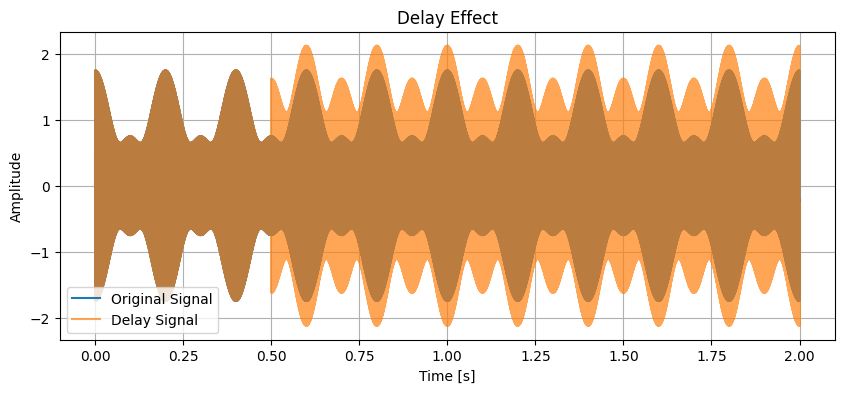

In [14]:
def delay_effect(input_signal, sample_rate, delay_time=0.5, feedback=0.5):
    delay_samples = int(delay_time * sample_rate)
    output_signal = np.zeros(len(input_signal) + delay_samples)
    output_signal[:len(input_signal)] = input_signal
    
    for i in range(len(input_signal)):
        output_signal[i + delay_samples] += feedback * input_signal[i]
    
    return output_signal[:len(input_signal)]

# Example usage
delay_signal = delay_effect(waveform, sample_rate)

plt.figure(figsize=(10, 4))
plt.plot(t, waveform, label='Original Signal')
plt.plot(t, delay_signal, label='Delay Signal', alpha=0.7)
plt.title('Delay Effect')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# <font color = 'green'> **Effect 5 : Reverberation**

Delays: [197, 198, 199]
Gains: [0.25920389 0.22303452 0.38643852 0.28095351]


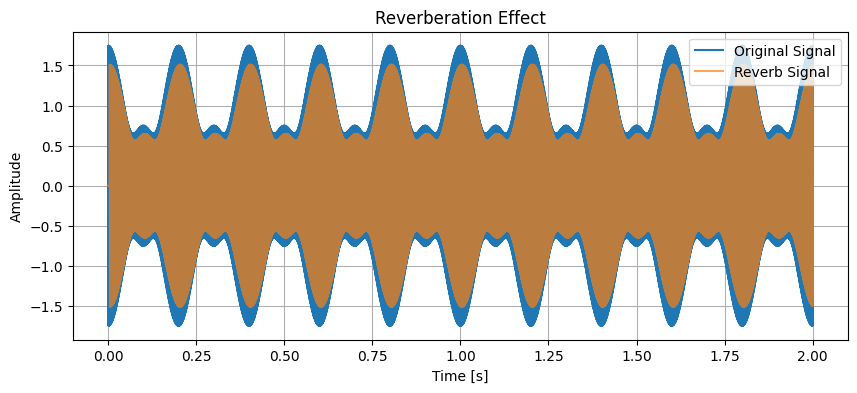

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from math import gcd
from functools import reduce

def are_coprime(delays):
    for i in range(len(delays)):
        for j in range(i + 1, len(delays)):
            if gcd(delays[i], delays[j]) != 1:
                return False
    return True

def generate_coprime_delays(num_delays, max_delay):
    delays = []
    for delay in range(1, max_delay):
        delays.append(delay)
        if len(delays) == num_delays and are_coprime(delays):
            break
        elif len(delays) == num_delays:
            delays.pop(0)  # Remove the first element to maintain the number of delays
    return delays

def reverb_effect(signal, sample_rate, delays, gains):
    max_delay = max(delays)
    delayed_signals = np.zeros((len(delays), len(signal) + max_delay))
    
    for i, delay in enumerate(delays):
        delayed_signal = np.pad(signal, (delay, 0))[:len(signal)]
        delayed_signals[i, :len(delayed_signal)] += gains[i] * delayed_signal
    
    reverb_signal = np.sum(delayed_signals, axis=0)[:len(signal)]
    return reverb_signal

# Generate delays and corresponding gains
num_delays = 4
max_delay = 200  # max delay in samples
delays = generate_coprime_delays(num_delays, max_delay)
gains = np.random.uniform(0.2, 0.5, num_delays)  # random gains for each delay line

print(f"Delays: {delays}")
print(f"Gains: {gains}")


# Apply the reverb effect
reverb_signal = reverb_effect(waveform, sample_rate, delays, gains)

# Plot the original and reverb signal
plt.figure(figsize=(10, 4))
plt.plot(t, waveform, label='Original Signal')
plt.plot(t, reverb_signal, label='Reverb Signal', alpha=0.7)
plt.title('Reverberation Effect')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# <font color = 'green'> **Effect 6 : Pitch shifter**

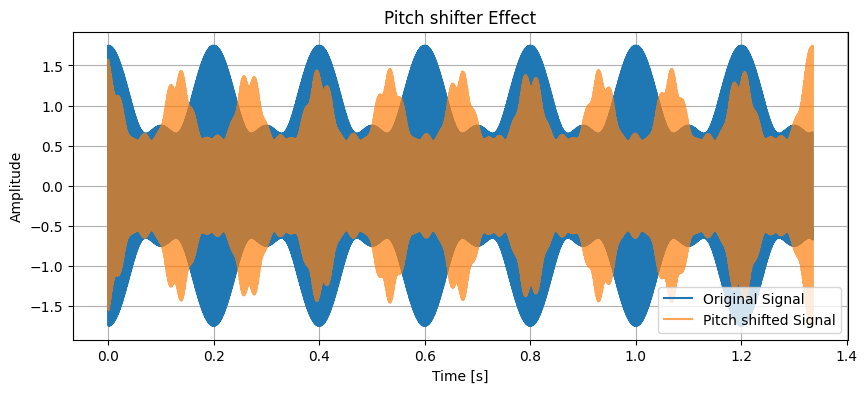

In [16]:
def phase_vocoder(signal, rate, pitch_shift_ratio):
    hop_length = 512
    n_fft = 2048
    D = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    
    phase = np.angle(D)
    magnitude = np.abs(D)
    
    time_steps = np.arange(0, magnitude.shape[1], pitch_shift_ratio)
    
    D_new = np.zeros((magnitude.shape[0], len(time_steps)), dtype=complex)
    
    for t, step in enumerate(time_steps):
        i = int(np.floor(step))
        frac = step - i
        if i + 1 < magnitude.shape[1]:
            D_new[:, t] = (1 - frac) * magnitude[:, i] * np.exp(1j * phase[:, i]) + frac * magnitude[:, i + 1] * np.exp(1j * phase[:, i + 1])
        else:
            D_new[:, t] = magnitude[:, i] * np.exp(1j * phase[:, i])
    
    signal_out = librosa.istft(D_new, hop_length=hop_length)
    return signal_out


if len(waveform.shape) > 1:  
    signal = waveform.mean(axis=1)

pitch_shift_ratio = 1.5  
pitch_shifted_signal = phase_vocoder(waveform, sample_rate , pitch_shift_ratio)

t = np.arange(min(len(waveform), len(pitch_shifted_signal))) / sample_rate

plt.figure(figsize=(10, 4))
plt.plot(t, waveform[:len(t)], label='Original Signal')
plt.plot(t, pitch_shifted_signal[:len(t)], label='Pitch shifted Signal', alpha=0.7)
plt.title('Pitch shifter Effect')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# <font color = 'green'> **Effect 7 : Vocoder**

In [ ]:
def vocoder_effect(modulator, carrier, frame_size, overlap):
    hop_size = frame_size - overlap
    
    # STFT of the modulator and carrier signals
    _, _, modulator_frames = scipy.signal.stft(modulator, nperseg=frame_size, noverlap=overlap)
    _, _, carrier_frames = scipy.signal.stft(carrier, nperseg=frame_size, noverlap=overlap)
    
    vocoded_frames = []
    for m_frame, c_frame in zip(modulator_frames.T, carrier_frames.T):
        m_magnitude = np.abs(m_frame)
        c_phase = np.angle(c_frame)
        vocoded_frame = m_magnitude * np.exp(1j * c_phase)
        vocoded_frames.append(vocoded_frame)
    
    vocoded_frames = np.array(vocoded_frames).T
    _, vocoded_signal = scipy.signal.istft(vocoded_frames, nperseg=frame_size, noverlap=overlap)

    return np.real(vocoded_signal)

# Example usage
modulator = np.random.randn(44100)  # Replace with actual modulator signal
carrier = np.random.randn(44100)    # Replace with actual carrier signal
frame_size = 1024
overlap = 512

vocoded_signal = vocoder_effect(modulator, carrier, frame_size, overlap)

# Save or process vocoded_signal as needed
import matplotlib.pyplot as plt

# Plot the original and vocoded signals for comparison
plt.figure(figsize=(12, 6))
t = np.linspace(0, len(modulator)/44100, len(modulator))
plt.plot(t, modulator, label='Original Modulator Signal')
plt.plot(t, vocoded_signal, label='Vocoded Signal', linestyle='--')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Vocoder Effect')
plt.show()


# <font color = 'green'> **Effect 8 : Saturation**

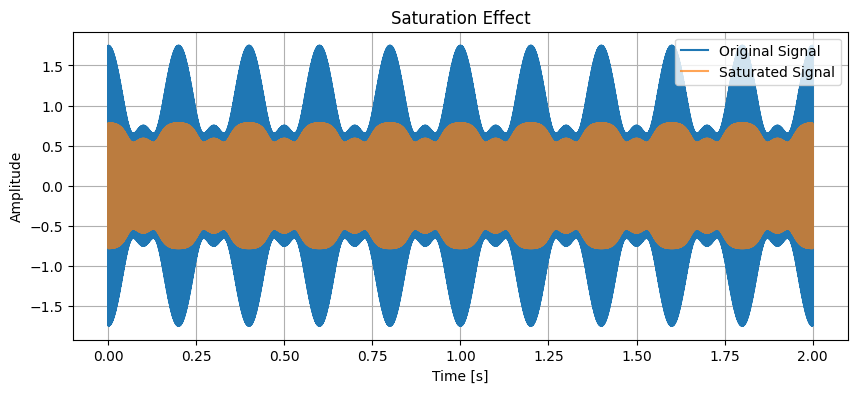

In [17]:
def saturation_effect(signal, T=0.8):
    return T * np.tanh(signal / T)

# Assuming waveform and sample_rate are defined correctly

if len(waveform.shape) > 1:  
    signal = waveform.mean(axis=1)

t = np.arange(len(waveform)) / sample_rate
saturated_signal = saturation_effect(waveform, 0.8)

# Plot the original and saturated signal
plt.figure(figsize=(10, 4))
plt.plot(t, waveform[:len(t)], label='Original Signal')
plt.plot(t, saturated_signal[:len(t)], label='Saturated Signal', alpha=0.7)
plt.title('Saturation Effect')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# <font color = 'green'> **Effect 9 : Compressor**

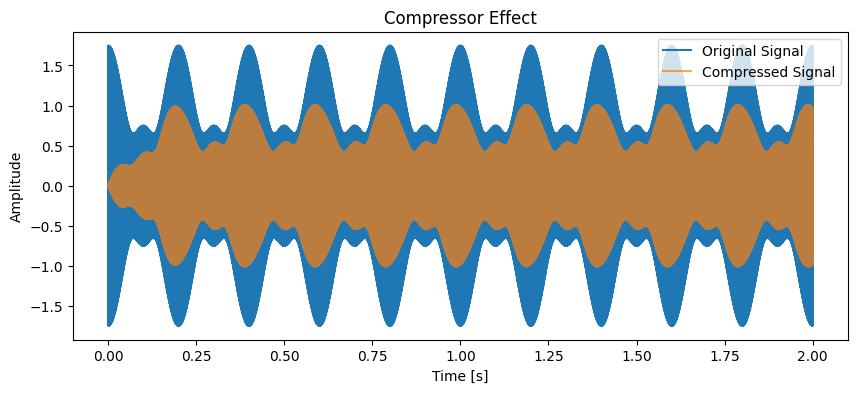

In [18]:
def compressor(signal, threshold, ratio, attack, release, sample_rate):
    # Convert attack and release times from milliseconds to samples
    attack_samples = int(attack * sample_rate / 1000)
    release_samples = int(release * sample_rate / 1000)
    
    # Calculate attack and release coefficients
    attack_coeff = 1.0 - np.exp(-1.0 / attack_samples)
    release_coeff = 1.0 - np.exp(-1.0 / release_samples)
    
    # Initialize gain
    gain = np.ones_like(signal)
    env = 0.0
    
    for i in range(len(signal)):
        abs_sample = abs(signal[i])
        if abs_sample > threshold:
            target_gain = threshold + (abs_sample - threshold) / ratio
            target_gain = target_gain / abs_sample
        else:
            target_gain = 1.0
        
        if target_gain < env:
            env = attack_coeff * (target_gain - env) + env
        else:
            env = release_coeff * (target_gain - env) + env
        
        gain[i] = env
    
    # Apply gain to the signal
    compressed_signal = gain * signal
    return compressed_signal

# Example usage
sample_rate = 44100  # 44.1 kHz sample rate
threshold = 0.5      # Threshold for compression
ratio = 4.0          # Compression ratio
attack = 10          # Attack time in milliseconds
release = 100        # Release time in milliseconds

# Generate a sample signal (replace with actual signal)
t = np.arange(len(waveform)) / sample_rate

compressed_signal = compressor(waveform, threshold, ratio, attack, release, sample_rate)

# Plot the original and compressed signals for comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(t, waveform, label='Original Signal')
plt.plot(t, compressed_signal[:len(t)], label='Compressed Signal', alpha=0.7)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Compressor Effect')
plt.show()


# <font color = 'green'> **Effect 10 : Voltage-Controlled Filter**

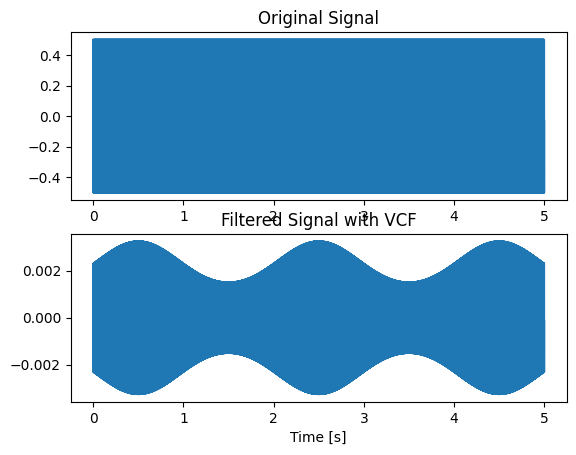

In [14]:
def create_lfo(frequency, sample_rate, length):
    t = np.linspace(0, length, int(sample_rate * length), endpoint=False)
    lfo = 0.2 * np.sin(2 * np.pi * frequency * t)
    return lfo

def apply_vcf(signal, sample_rate, cutoff, lfo):
    nyquist = 0.5 * sample_rate
    lfo_len = len(lfo)
    filtered_signal = np.zeros_like(signal)
    
    for i in range(len(signal)):
        modulated_cutoff = cutoff * (1 + lfo[i % lfo_len])
        b, a = butter(2, modulated_cutoff / nyquist, btype='low')
        filtered_signal[i] = lfilter(b, a, [signal[i]])[0]
    
    return filtered_signal


sample_rate = 44100  # Define the sample rate
signal_length = 5  # Define the length of the signal
cutoff_frequency = 1000  # Define the cutoff frequency

# Generate a time array
time = np.linspace(0, signal_length, int(sample_rate * signal_length), endpoint=False)

frequency = 440  # Define the frequency of the sinusoidal waveform
amplitude = 0.5  # Define the amplitude of the sinusoidal waveform

# Generate the sinusoidal waveform
signal = amplitude * np.sin(2 * np.pi * frequency * time)

lfo_frequency = 0.5  # Define the LFO frequency
lfo = create_lfo(lfo_frequency, sample_rate, signal_length)

filtered_signal = apply_vcf(signal, sample_rate, cutoff_frequency, lfo)

# Adjust the length of filtered_signal to match the time array
filtered_signal = filtered_signal[:len(time)]

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time, signal)
plt.title('Original Signal')
plt.subplot(2, 1, 2)
plt.plot(time, filtered_signal)
plt.title('Filtered Signal with VCF')
plt.xlabel('Time [s]')
plt.show()

# <font color = 'red'> **Final Result, Passed From All Effects :**

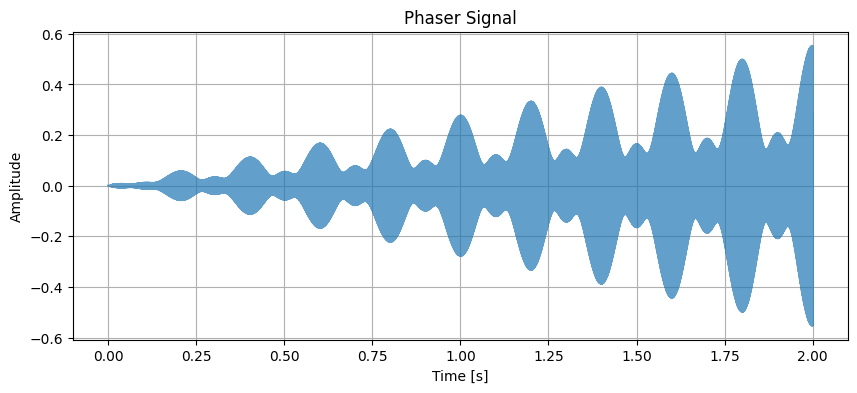

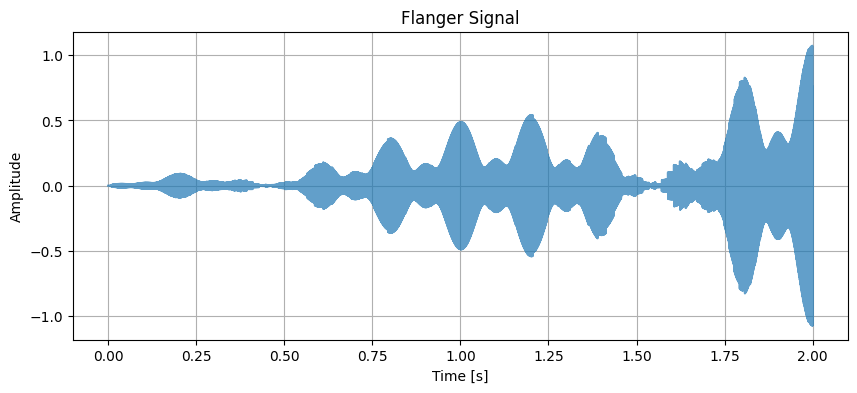

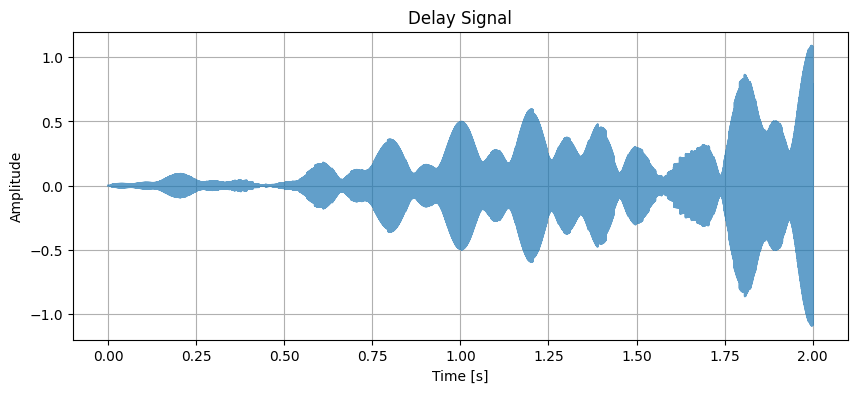

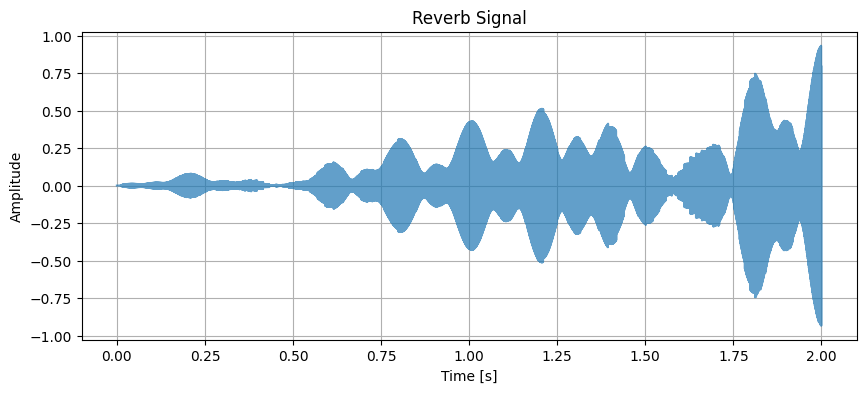

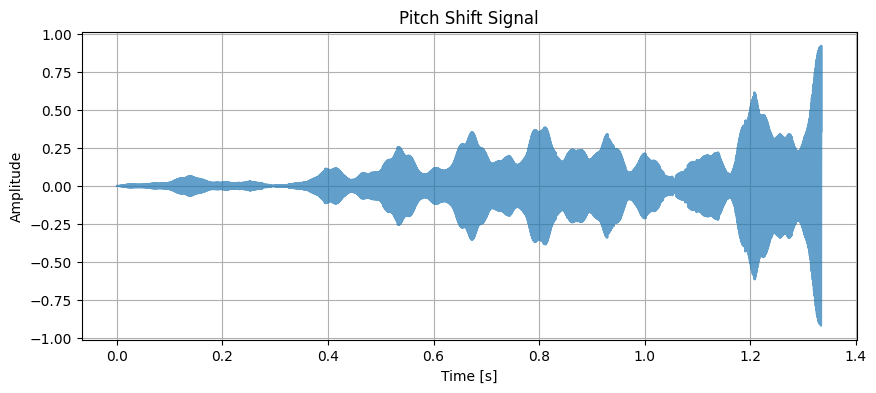

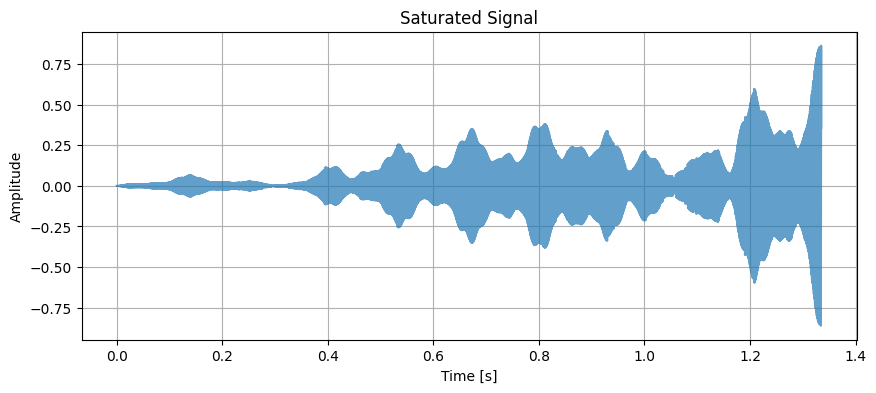

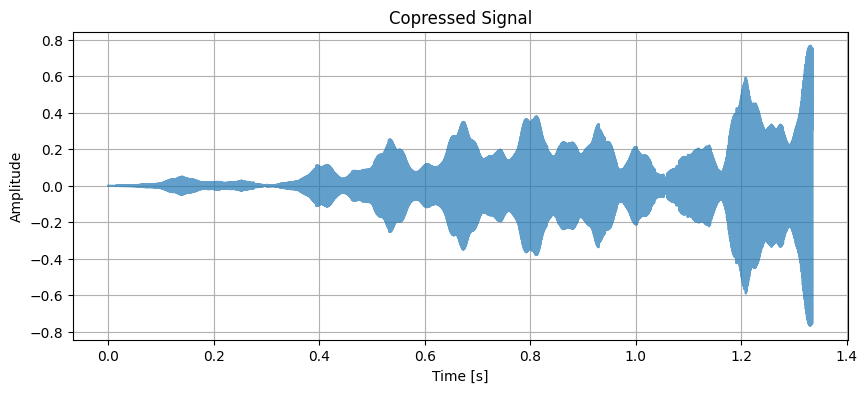

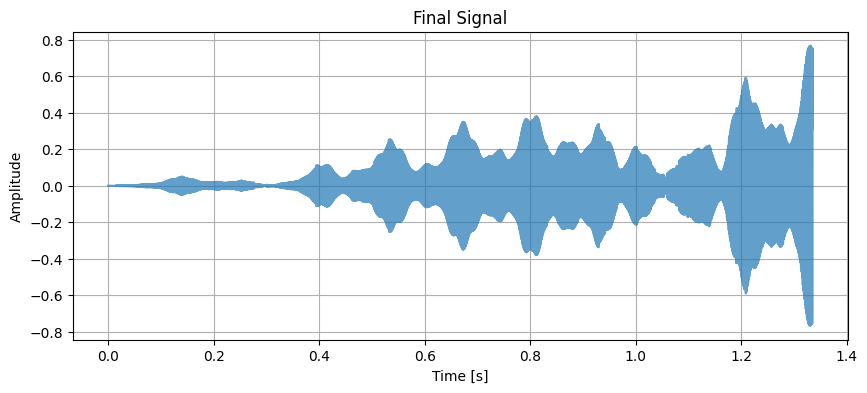

In [31]:
# Generate the initial waveform
waveform = detuned_wave(wave_type, t, base_frequency, phase, volume, N, Ais, fis)

# Apply the AHDSR envelope
enveloped_waveform = apply_ahdsr_envelope(waveform, t, attack, hold, decay, sustain, release, note_length)

# Apply the reverb effect
reverb_signal = reverb_effect(enveloped_waveform, sample_rate, delays, gains)

# Apply the phaser effect
phaser_signal = phaser_effect(reverb_signal, sample_rate)

plt.figure(figsize=(10, 4))
plt.plot(t[:len(phaser_signal)], phaser_signal, alpha=0.7)
plt.title('Phaser Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Apply the Delay effect
flanger_signal = flanger_effect(phaser_signal, sample_rate)

plt.figure(figsize=(10, 4))
plt.plot(t[:len(flanger_signal)], flanger_signal, alpha=0.7)
plt.title('Flanger Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Apply the delay effect
delay_signal = delay_effect(flanger_signal, sample_rate)

plt.figure(figsize=(10, 4))
plt.plot(t[:len(delay_signal)], delay_signal, alpha=0.7)
plt.title('Delay Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

#Apply the reverberation effect
reverb_signal = reverb_effect(delay_signal, sample_rate, delays, gains)

plt.figure(figsize=(10, 4))
plt.plot(t[:len(reverb_signal)], reverb_signal, alpha=0.7)
plt.title('Reverb Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

#Apply the pitch shifter effect
pitch_shifted_signal = phase_vocoder(reverb_signal, sample_rate , pitch_shift_ratio)

plt.figure(figsize=(10, 4))
plt.plot(t[:len(pitch_shifted_signal)], pitch_shifted_signal, alpha=0.7)
plt.title('Pitch Shift Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

#Apply the saturation effect
saturated_signal = saturation_effect(pitch_shifted_signal,2)

plt.figure(figsize=(10, 4))
plt.plot(t[:len(saturated_signal)], saturated_signal, alpha=0.7)
plt.title('Saturated Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

#Apply the compressor effect
compressed_signal = compressor(saturated_signal, threshold, ratio, attack, release, sample_rate)

plt.figure(figsize=(10, 4))
plt.plot(t[:len(compressed_signal)], compressed_signal, alpha=0.7)
plt.title('Copressed Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


final_signal = compressed_signal
# Plot the final output
plt.figure(figsize=(10, 4))
plt.plot(t[:len(final_signal)], final_signal, alpha=0.7)
plt.title('Final Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


# <font color = 'pink'> **Save It As A Music**

In [32]:
import numpy as np
from scipy.io import wavfile

normalized_signal = compressed_signal / np.max(np.abs(compressed_signal))

scaled_signal = np.int16(normalized_signal * 32767)

wavfile.write("output.wav", sample_rate, scaled_signal)
